# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.40KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

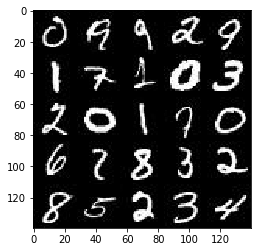

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

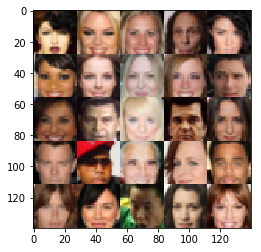

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.1, keep_prob=0.75):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        #Dropout
        p = tf.placeholder(tf.float32, name='keep_prob')
        layer_4 = tf.layers.dropout(layer_4, p)
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.sigmoid(logits)
        
        return output, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0585... Generator Loss: 0.2555
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 1.2462
Epoch 1/2... Discriminator Loss: 1.5660... Generator Loss: 0.4601
Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 1.3936
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.0190
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 1.4893
Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 0.6093


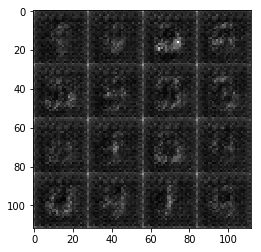

Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 1.2558
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.2726
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.4074
Epoch 1/2... Discriminator Loss: 0.9720... Generator Loss: 1.0994
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.4732
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 0.9922


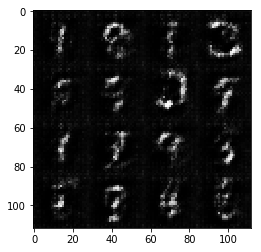

Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 2.0849
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 2.0454
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.0532
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 1.0969
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 0.7194


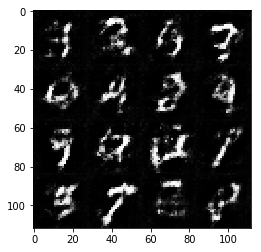

Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.6407
Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 1.0118
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.5442
Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.4726
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.1590
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 0.9605


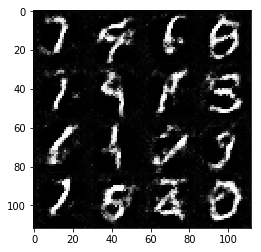

Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.2959
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 1.8901
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 1.4318
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 0.9090... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 1.0478
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 1.2430


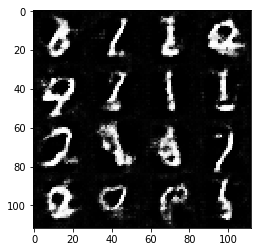

Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 1.5520
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 1.5855
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.5293
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 1.0250
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 0.9785
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 1.5377
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 1.2147


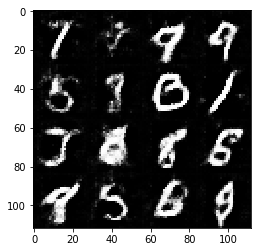

Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 1.5425
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.3537
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.5677
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 0.9541... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.1070


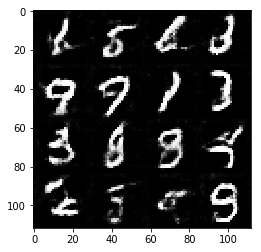

Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 1.5271
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 2.0841
Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.4774
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 0.8659
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.3044


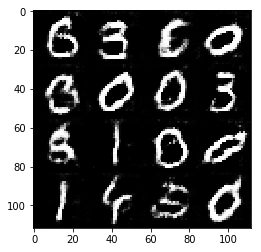

Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 1.0314
Epoch 1/2... Discriminator Loss: 0.9411... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 0.3557
Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.2351
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 1.0051... Generator Loss: 1.1302


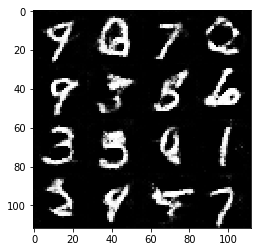

Epoch 1/2... Discriminator Loss: 2.0124... Generator Loss: 0.2528
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.7596
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.5639
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.0861
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 1.7939
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.8024


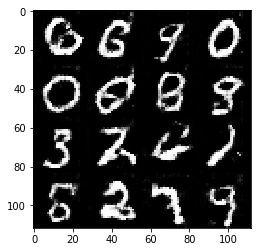

Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 1.2345
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.3745
Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 1.4579... Generator Loss: 0.4593
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6151
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.3065
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 0.7753


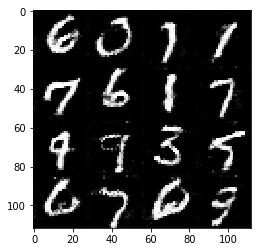

Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.0921
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 1.8293
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 1.1920
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 1.7706
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 0.7620
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.9161


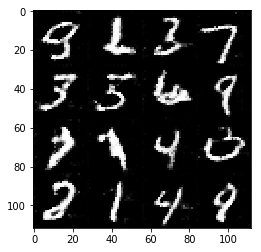

Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.6028
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.4430
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.1285
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 1.6007
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 0.8085... Generator Loss: 1.1729


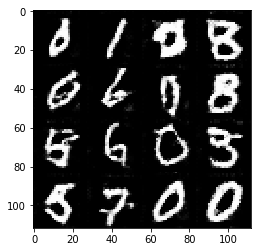

Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 1.0744
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 0.8978
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.7625
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 1.6441


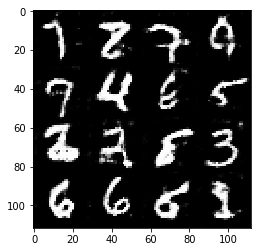

Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 1.1553
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 1.4958
Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 1.1672
Epoch 2/2... Discriminator Loss: 1.6420... Generator Loss: 0.3828
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 1.5042
Epoch 2/2... Discriminator Loss: 0.9753... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.8312
Epoch 2/2... Discriminator Loss: 2.7090... Generator Loss: 0.1475
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 1.1550


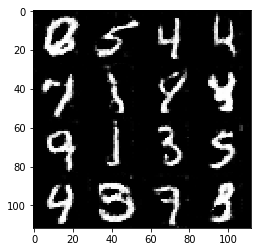

Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 0.9454
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.3589
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.5072
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 1.0882
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 2.2923
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 1.7870


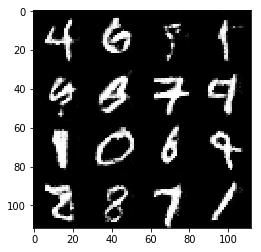

Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 1.5473
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.2683
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.7328
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.4444


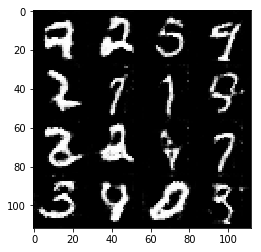

Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 0.6668
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 0.4099
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 1.3616
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.9237
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.3676
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.5094... Generator Loss: 0.4279


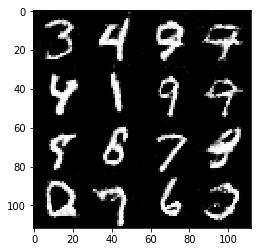

Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.5669
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.2032
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.5862
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.1449


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.9589
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.7704
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.5538
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.1538
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 3.7259
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 2.2160


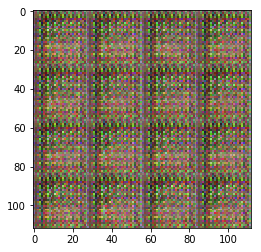

Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 3.6775
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 2.6735
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 2.3369
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.2649
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.6651
Epoch 1/1... Discriminator Loss: 1.7563... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.9974


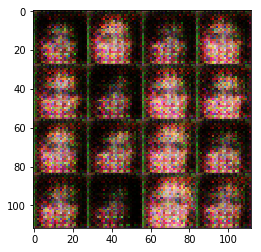

Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 1.8980
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 3.4405
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 2.0598
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.6874


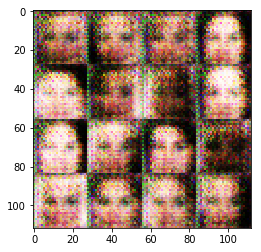

Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 2.3146
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.9200
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 1.7722
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.4102
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 2.2184
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 2.2298
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.8838


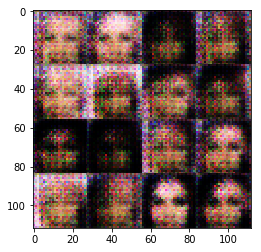

Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 2.1663
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.5816
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.6061


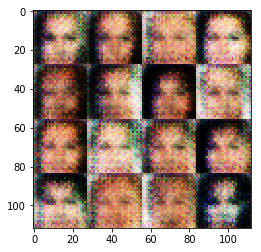

Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.7042
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.6792
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 2.4252
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.6350
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5262


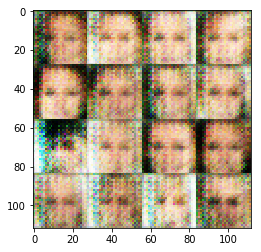

Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.7527
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.9282
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.5280


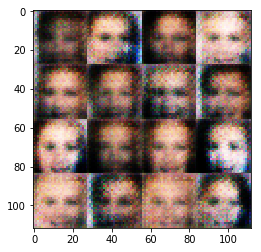

Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.3027


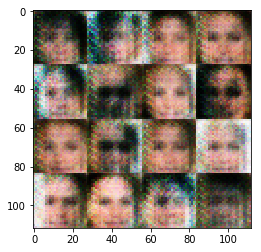

Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.5724
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.8009


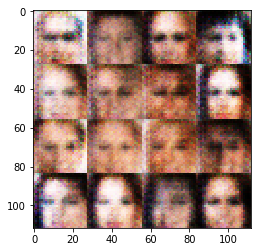

Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.3492


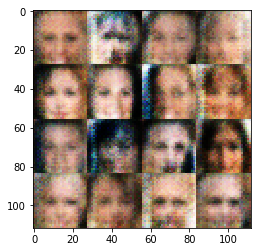

Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.4717
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.2095


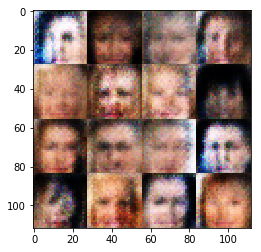

Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.9292
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.0590


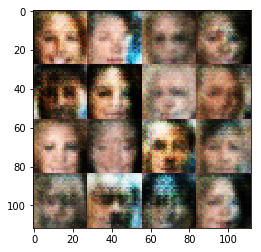

Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.3792
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.5049
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8247


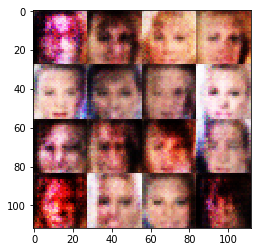

Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.5604
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8921


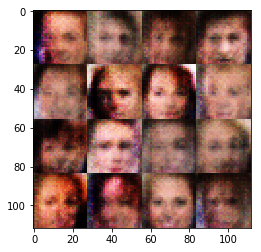

Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.7586
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.7221


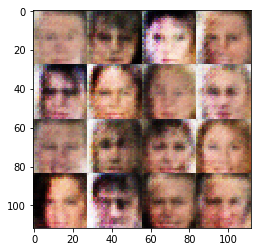

Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.8932


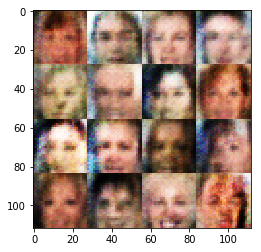

Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.7366


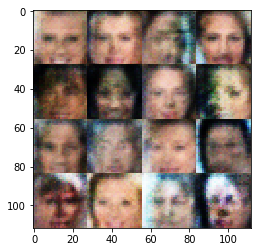

Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.0681


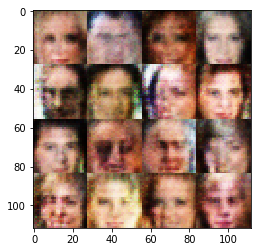

Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.0090


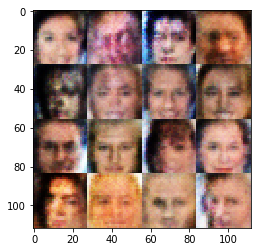

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.3832


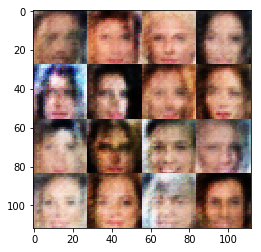

Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.5261
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.9121


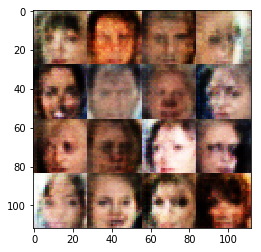

Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.4792


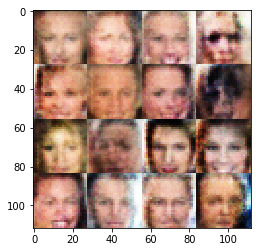

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.1057


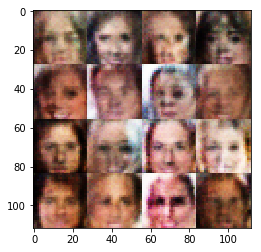

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.9465


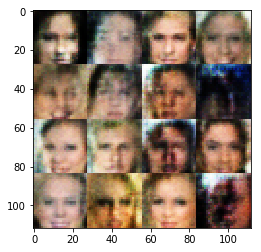

Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.0994


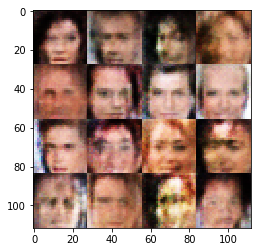

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6359


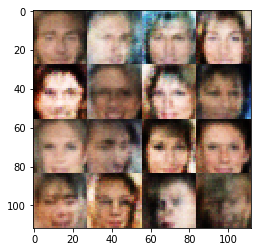

Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.4110
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.0079


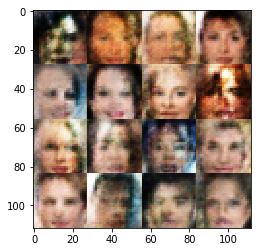

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.2559


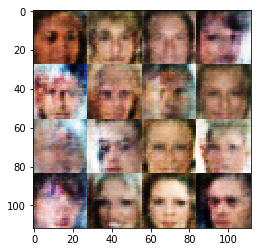

Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.0057


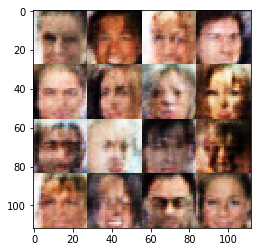

Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.8159


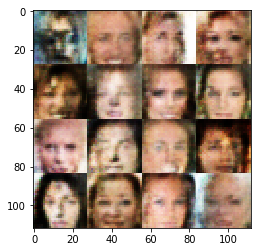

Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.0338


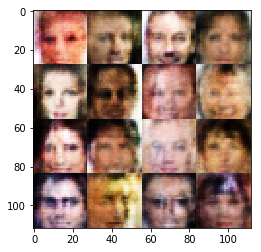

Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.3705


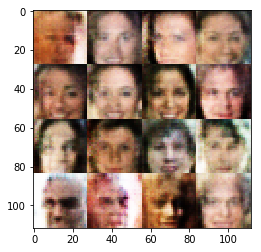

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.7889


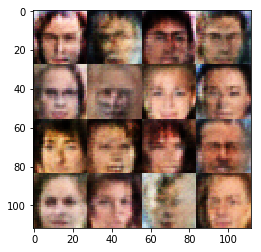

Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6525


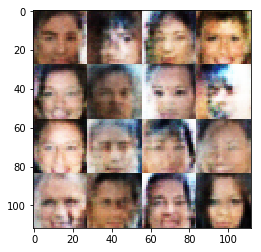

Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.7160


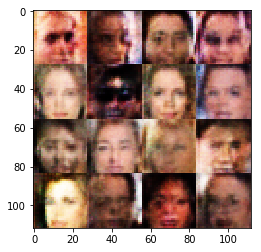

Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7067


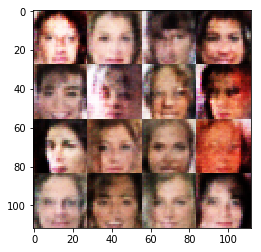

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5116


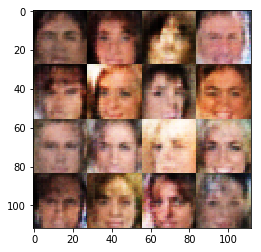

Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.5345


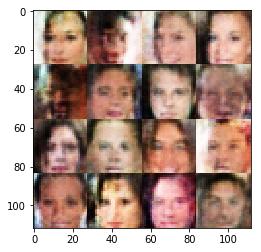

Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7714


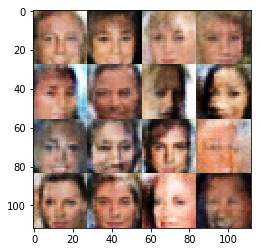

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.1916


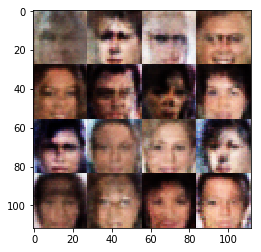

Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 1.2641
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.0981


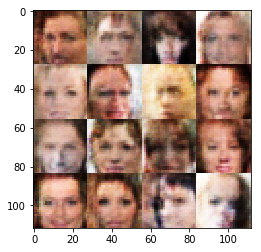

Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7997


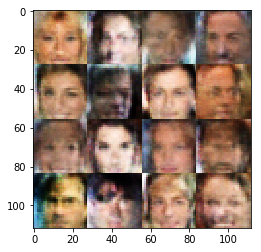

Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.6486
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.8012


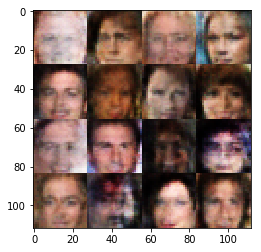

Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.6565
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.0725


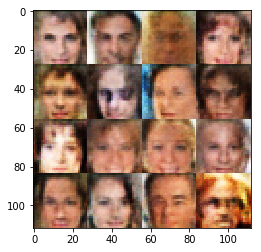

Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.6926


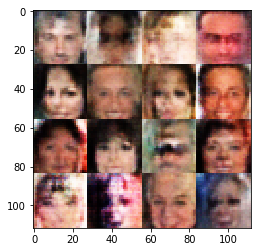

Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5546


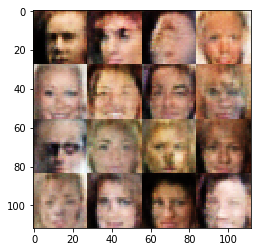

Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7060


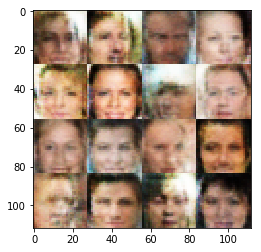

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7502


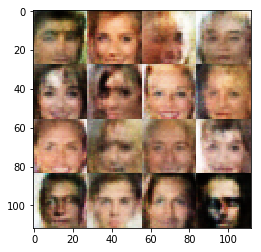

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6035


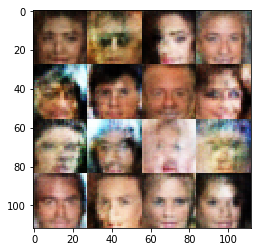

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.9869


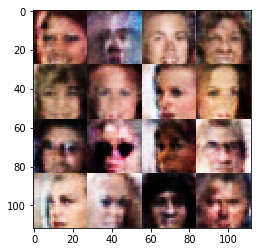

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.8635


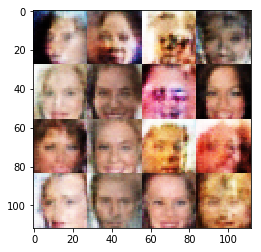

Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.0475


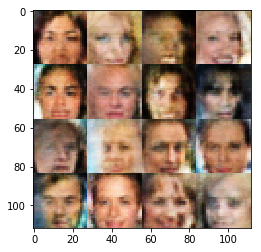

Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.7782


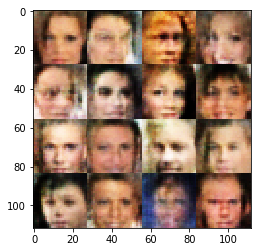

Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.4625


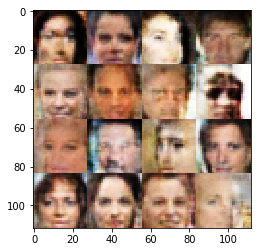

Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.1025


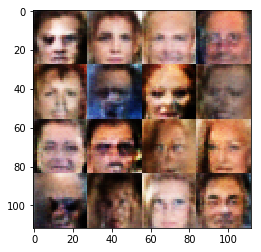

Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.4090


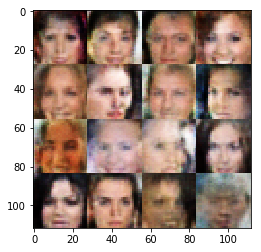

Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.8411


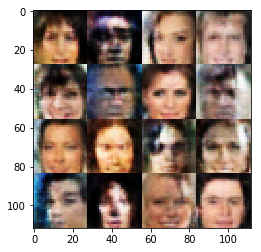

Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.5468
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.8788


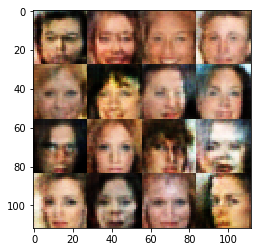

Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.6993


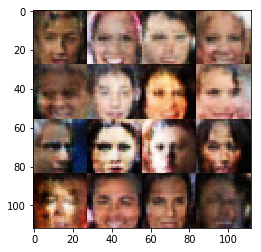

Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.3272
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.0444


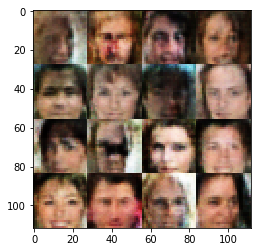

Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.3404


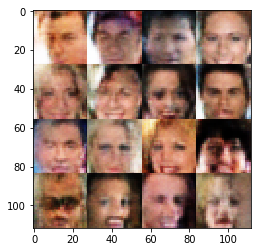

Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7488


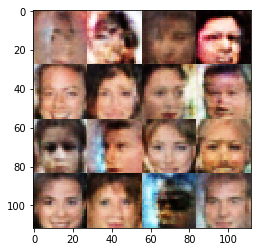

Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.8985


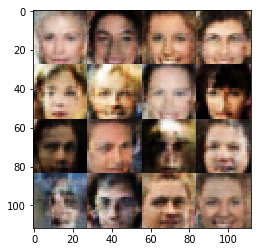

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.8235


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.